# Text mining 

* Identificar las palabras empleadas por reconocidos usuarios de twitter.

* Crear un modelo de machine learning capaz de clasificar la autor√≠a de las publicaciones en base a su texto.

* An√°lisis de sentimientos.


# Extracci√≥n datos Twitter

Como ocurre en muchas redes sociales, la propia plataforma pone a disposici√≥n de los usuarios una API que permite extraer informaci√≥n. Aunque en la mayor√≠a de casos se trata de web services API, con frecuencia existen librer√≠as que permiten interactuar con la API desde diversos lenguajes de programaci√≥n. Un ejemplo de ello es Tweepy, un wrapper de Python que se comunica con la API de Twitter.

Debido a que estas APIs se actualizan con relativa frecuencia, y para evitar que el documento deje de mostrar c√≥digo funcional, se emplean tweets ya extra√≠dos y que pueden encontrarse en el repositorio de github. Los tweets pertenecen a:

Elon Musk (@elonmusk) y Bill Gates (@BillGates), dos directivos de empresas tecnol√≥gicas.

Mayor Ed Lee (@mayoredlee) alcalde de la ciudad de San Francisco.


In [1]:
# Tratamiento de datos

import numpy as np
import pandas as pd
import string
import re
'''
Una expresi√≥n regular (o RE, por sus siglas en ingl√©s) especifica un conjunto
de cadenas que coinciden con ella; las funciones de este m√≥dulo permiten comprobar
si una determinada cadena coincide con una expresi√≥n regular dada.
https://docs.python.org/es/3/library/re.html

'''
# Gr√°ficos

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado

from sklearn import svm # clasificador support vector machines
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# cambiador de formatos para factorizar un dataset
from sklearn.feature_extraction.text import TfidfVectorizer 

# Configuraci√≥n warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
!{sys.executable} -m pip install nltk

In [3]:
import nltk # natural lenguaje tool kit para procesamiento de lenguaje natural
nltk.download('stopwords')
from nltk.corpus import stopwords # palabras conectoras que repetimos con frecuencia en un idioma


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joseb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Datos
para el ejemplo se utiliza una base de datos de tweets recopilados de las 3 personas en 2017

In [4]:
# Lectura de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('N√∫mero de tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('N√∫mero de tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('N√∫mero de tweets @elonmusk: ' + str(tweets_elon.shape[0]))

N√∫mero de tweets @BillGates: 2087
N√∫mero de tweets @mayoredlee: 2447
N√∫mero de tweets @elonmusk: 2678


In [5]:
from IPython.core.display import HTML

# Se unen los tres dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas de inter√©s
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
#tweets.head(3)
display(HTML(tweets.to_html()))

### Distribuci√≥n temporal de los tweets


Dado que cada usuario puede haber iniciado su actividad en Twitter en diferente momento, es interesante explorar si los tweets recuperados comparten el mismo tiempo.


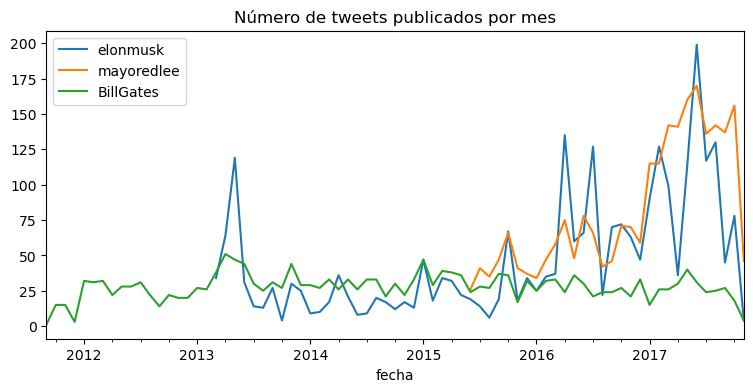

In [6]:
# Distribuci√≥n temporal de los tweets

fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
#en la columna autor busca y ejecuta el loop teniendo como contador cada unico posible autor
    df_temp = tweets[tweets['autor'] == autor].copy()
    #crea un marco de datos temporal 'df_temp' que contiene s√≥lo los tweets del autor actual.

    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
#convierte la columna 'fecha' de 'df_temp' en un objeto datetime con el formato '%Y-%m' (a√±o-mes).
    
    df_temp = df_temp.groupby(df_temp['fecha']).size()
#agrupa el marco de datos 'df_temp' por la columna 'fecha' y cuenta el n√∫mero de tweets de cada 
# mes.
    
    df_temp.plot(label=autor, ax=ax)
# Esta l√≠nea traza el n√∫mero de tweets de cada mes en el objeto de eje actual 'ax' y etiqueta 
#el gr√°fico con el nombre del autor.
ax.set_title('N√∫mero de tweets publicados por mes')
ax.legend(); # poner ; al final de una isntruccion hace que se ejecute en vez de mostrarse como output



Puede observarse un perfil de actividad distinto para cada usuario. Bill Gates ha mantenido una actividad constante de en torno a 30 tweets por mes durante todo el periodo estudiado. Elon Musk muestra una actividad inicial por debajo de la de Bill Gates pero, a partir de febrero de 2016, increment√≥ notablemente el n√∫mero de tweets publicados. Ed Lee tiene una actividad muy alta sobre todo en el periodo 2017. Debido a las limitaciones que impone Twitter en las recuperaciones, cuanto m√°s activo es un usuario, menor es el intervalo de tiempo para el que se recuperan tweets. En el caso de Ed Lee, dado que publica con mucha m√°s frecuencia que el resto, con la misma cantidad de tweets recuperados se abarca menos de la mitad del rango temporal que con los otros.

# Limpieza y Tokenizaci√≥n


El proceso de limpieza de texto, dentro del √°mbito de text mining, consiste en eliminar del texto todo aquello que no aporte informaci√≥n sobre su tem√°tica, estructura o contenido. No existe una √∫nica forma de hacerlo, depende en gran medida de la finalidad del an√°lisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuaci√≥n. En este ejercicio, se procede a eliminar: patrones no informativos (urls de p√°ginas web), signos de puntuaci√≥n, etiquetas HTML, caracteres sueltos y n√∫meros.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por token el elemento m√°s sencillo con significado propio para el an√°lisis en cuesti√≥n, en este caso, las palabras.

Existen m√∫ltiples librer√≠as que automatizan en gran medida la limpieza y tokenizaci√≥n de texto, por ejemplo, la clase feature_extraction.text.CountVectorizer de Scikit Learn, nltk.tokenize o spaCy. A pesar de ello, para este ejemplo, se define una funci√≥n que, si bien est√° menos optimizada, tiene la ventaja de poder adaptarse f√°cilmente dependiendo del tipo de texto analizado. (tokenizador manual y customizable)

In [7]:
print("______________________________________________________________________")
print(string.punctuation)
print(re.escape(string.punctuation))
print("______________________________________________________________________")

______________________________________________________________________
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~
______________________________________________________________________


In [8]:
def limpiar_tokenizar(texto):
    '''
    Esta funci√≥n limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuaci√≥n se ha obtenido de: string.punctuation
    y re.escape(string.punctuation)
    
    print("______________________________________________________________________")
    print(string.punctuation)
    print(re.escape(string.punctuation))
    print("______________________________________________________________________")
    
    '''

    
    # Se convierte todo el texto a min√∫sculas
    nuevo_texto = texto.lower()
    # Eliminaci√≥n de p√°ginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminaci√≥n de signos de puntuaci√≥n
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\
    \-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminaci√≥n de n√∫meros
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminaci√≥n de espacios en blanco m√∫ltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenizaci√≥n por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminaci√≥n de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


La funci√≥n limpiar_tokenizar() elimina el s√≠mbolo @ y # de las palabras a las que acompa√±an. En Twitter, los usuarios se identifican de esta forma, por lo que @ y # pertenecen al nombre. Aunque es importante tener en cuenta las eliminaciones del proceso de limpieza, el impacto en este caso no es demasiado alto, ya que, si un documento se caracteriza por tener la palabra #datascience, tambi√©n ser√° detectado f√°cilmente mediante la palabra datascience.

In [9]:
# Se aplica la funci√≥n de limpieza y tokenizaci√≥n a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

texto  \
0  "If one day, my words are against science, cho...   
1  I placed the flowers\n\nThree broken ribs\nA p...   
2          Atat√ºrk Anƒ±tkabir https://t.co/al3wt0njr6   
3         @Bob_Richards One rocket, slightly toasted   
4  @uncover007 500 ft so far. Should be 2 miles l...   

                                    texto_tokenizado  
0  [if, one, day, my, words, are, against, scienc...  
1  [placed, the, flowers, three, broken, ribs, pi...  
2                               [atat√ºrk, anƒ±tkabir]  
3    [bob, richards, one, rocket, slightly, toasted]  
4  [uncover, ft, so, far, should, be, miles, long...

# An√°lisis 


A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qu√© palabras emplea, con qu√© frecuencia, as√≠ como el significado de las mismas.

En Python, una de las estructuras que m√°s facilita el an√°lisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la informaci√≥n de los tweets. Sin embargo, al realizar la tokenizaci√≥n, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento as√≠ la condici√≥n de tidy data: una observaci√≥n, una fila. Al realizar la tokenizaci√≥n, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo as√≠ la condici√≥n de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansi√≥n o unnest.

Aunque puede parecer un proceso poco eficiente (el n√∫mero de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupaci√≥n, contaje, gr√°ficos...


In [10]:
# Unnest de la columna texto_tokenizado

tweets_tidy = tweets.explode(column='texto_tokenizado')
# La funci√≥n explode en pandas se utiliza para transformar cada elemento
# de una lista en una fila, replicando los valores del √≠ndice.
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

autor                     fecha            id token
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17    if
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   one
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   day

### Frecuencia de palabras

In [11]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [12]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

Aunque Elon Musk no es el que m√°s palabras totales ha utilizado, bien porque ha publicado menos tweets o porque estos son m√°s cortos, es el que m√°s palabras distintas emplea.(contenido de valor)

### Longitud media de tweets

In [13]:
# Longitud media y desviaci√≥n de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])
#el metodo agg aplica varias funciones a una misma celda o columna dentro de un pd_df

mean       std
autor                          
BillGates   15.144231  3.347354
elonmusk    12.611257  6.933870
mayoredlee  17.170152  3.486314

El tipo de tweet de Bill Gates y Mayor Ed Lee es similar en cuanto a longitud media y desviaci√≥n. Elon Musk alterna m√°s entre tweets cortos y largos, siendo su media inferior a la de los otros dos.

### Palabras m√°s utilizadas por autor

In [14]:
# Top 5 palabras m√°s utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

## Stop words

En la tabla anterior puede observarse que los t√©rminos m√°s frecuentes en todos los usuarios se corresponden con art√≠culos, preposiciones, pronombres‚Ä¶, en general, palabras que no aportan informaci√≥n relevante sobre el texto. Estas palabras se conocen como stopwords. Para cada idioma existen distintos listados de stopwords, adem√°s, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el t√©rmino amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un an√°lisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [15]:
# Obtenci√≥n de listado de stopwords del ingl√©s
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se a√±ade la stoprword: amp, xa, xe
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:100])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']


In [16]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]
'''
~(tweets_tidy["token"].isin(stop_words)): aplica el operador bitwise NOT (~) 
al resultado del m√©todo isin. Esto invierte los valores booleanos,
de modo que True se convierte en False y viceversa. 
Esto significa que las filas en las que el s√≠mbolo es un stopword 
tendr√°n ahora valores falsos, y las filas en las que el s√≠mbolo no es un stopword
tendr√°n valores verdaderos.
'''
print()




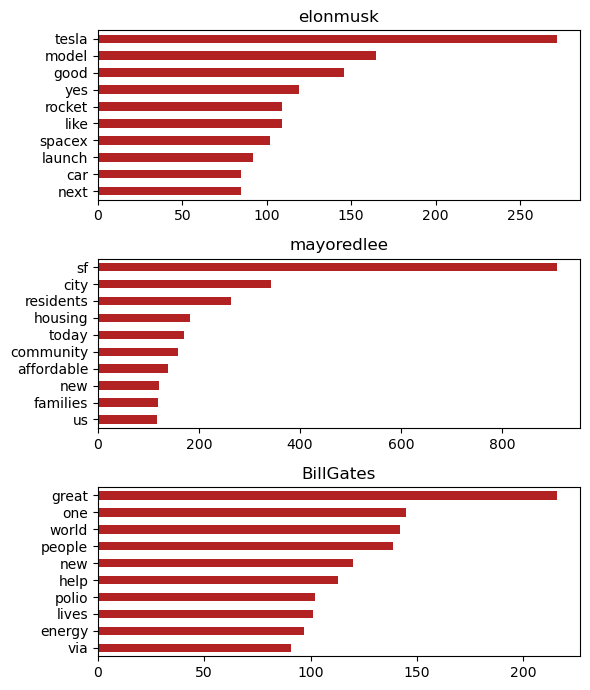

In [17]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

Los resultados obtenidos tienen sentido si ponemos en contexto la actividad profesional de los usuarios analizados. Mayor Ed Lee es alcalde de San Francisco (sf), por lo que sus tweets est√°n relacionados con la ciudad, residentes, familias, casas... Elon Musk dirige varias empresas tecnol√≥gicas entre las que destacan Tesla y SpaceX, dedicadas a los coches y a la aeron√°utica. Por √∫ltimo, Bill Gates, adem√°s de propietario de microsoft, dedica parte de su capital a fundaciones de ayuda, de ah√≠ las palabras mundo, polio, ayuda...

## Correlaci√≥n entre autores


Una forma de cuantificar la similitud entre los perfiles de dos usuarios de Twitter es calculando la correlaci√≥n en el uso de palabras. La idea es que, si dos usuarios escriben de forma similar, tender√°n a utilizar las mismas palabras y con frecuencias similares. La medida de similitud m√°s utilizada al trabajar con texto es 1 - distancia coseno.

Para poder generar los estudios de correlaci√≥n se necesita disponer de cada variable en una columna. En este caso, las variables a correlacionar son los autores.

In [18]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [19]:
pv_print=tweets_pivot[:100]
display(HTML(pv_print.to_html()))
print(f"total de palabras usadas por las 3 personas: {len(tweets_pivot)}")

total de palabras usadas por las 3 personas: 12707


In [20]:
# Test de correlaci√≥n (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

BillGates  elonmusk  mayoredlee
BillGates    1.000000  0.567274    0.496346
elonmusk     0.567274  1.000000    0.276732
mayoredlee   0.496346  0.276732    1.000000

In [21]:
# N√∫mero de palabras comunes
'''
set(): una estructura de datos incorporada en Python que almacena elementos √∫nicos
y proporciona pruebas r√°pidas de pertenencia.
'''
palabras_elon = set(tweets_tidy[tweets_tidy.autor == 'elonmusk']['token'])
palabras_bill = set(tweets_tidy[tweets_tidy.autor == 'BillGates']['token'])
palabras_edlee = set(tweets_tidy[tweets_tidy.autor == 'mayoredlee']['token'])

print(f"Palabras comunes entre Elon Musk y Ed Lee: {len(palabras_elon.intersection(palabras_edlee))}")
print(f"Palabras comunes entre Elon Elon Musk y Bill Gates: {len(palabras_elon.intersection(palabras_bill))}")

Palabras comunes entre Elon Musk y Ed Lee: 1760
Palabras comunes entre Elon Elon Musk y Bill Gates: 1758


Aunque el n√∫mero de palabras comunes entre Elon Musk y Bill Gates y entre Elon Musk y Ed Lee es similar, la correlaci√≥n basada en su uso es mayor entre Elon Musk y Bill Gates. Esto tiene sentido si se contempla el hecho de que ambos trabajan como directivos de empresas tecnol√≥gicas.

# Comparaci√≥n en el uso de palabras


A continuaci√≥n, se estudia qu√© palabras se utilizan de forma m√°s diferenciada por cada usuario, es decir, palabras que utiliza mucho un autor y que no utiliza el otro. Una forma de hacer este an√°lisis es mediante el log of odds ratio de las frecuencias. Esta comparaci√≥n se hace por pares, en este caso se comparan Elon Musk y Mayor Ed Lee.

log of odds ratio=https://en.wikipedia.org/wiki/Odds_ratio
 
Para realizar este c√°lculo es necesario que, para todos los usuarios, se cuantifique la frecuencia de cada una de las palabras que aparecen en el conjunto de tweets, es decir, si un autor no ha utilizado una de las palabras que s√≠ ha utilizado otro, debe aparecer esa palabra en su registro con frecuencia igual a cero. Existen varias formas de conseguir esto, una de ellas es pivotar y despivotar el dataframe sustituyendo los NaN por cero.

In [22]:
# C√°lculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)
# ==============================================================================
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
#La funci√≥n melt descompone el DataFrame tweets_pivot, que tiene un formato ancho, 
#en un formato largo. El DataFrame resultante tweets_unpivot tiene una sola columna
#para los valores (denominada 'n') y otra columna para los nombres de las variables
#(denominada 'autor').
tweets_unpivot = tweets_unpivot.reset_index()

# Selecci√≥n de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['elonmusk', 'mayoredlee'])]

# Se a√±ade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )


In [23]:
# C√°lculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.elonmusk/tweets_logOdds.mayoredlee)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es as√≠ porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "elonmusk",
                                              "mayoredlee"
                                            )

In [24]:
print('-----------------------------------')
print('Top 10 palabras m√°s diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras m√°s diferenciadoras
-----------------------------------


elonmusk  mayoredlee  log_odds  abs_log_odds autor_frecuente
token                                                                  
tesla      0.012569    0.000037  5.815040      5.815040        elonmusk
residents  0.000046    0.009934 -5.374162      5.374162      mayoredlee
yes        0.005525    0.000037  4.993060      4.993060        elonmusk
rocket     0.005064    0.000037  4.906049      4.906049        elonmusk
community  0.000046    0.005960 -4.863336      4.863336      mayoredlee
spacex     0.004742    0.000037  4.840297      4.840297        elonmusk
sf         0.000276    0.034112 -4.816117      4.816117      mayoredlee
falcon     0.003775    0.000037  4.612288      4.612288        elonmusk
landing    0.003039    0.000037  4.395223      4.395223        elonmusk
housing    0.000092    0.006860 -4.310771      4.310771      mayoredlee

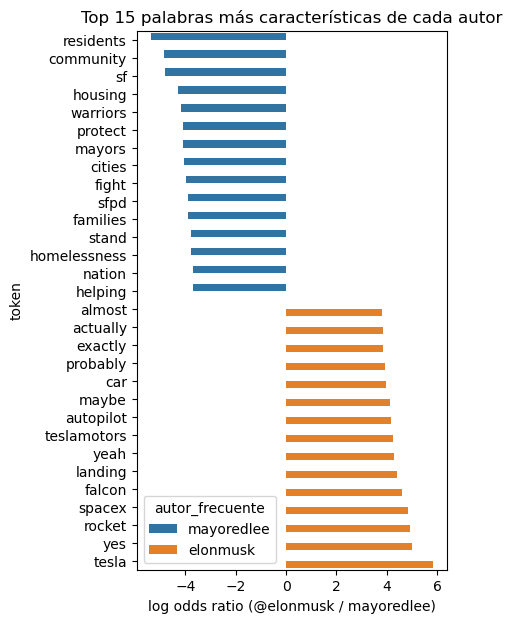

In [25]:
# Top 15 palabras m√°s caracter√≠sticas de cada autor
# ==============================================================================

top_15 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_15,
    ax   = ax
)
ax.set_title('Top 15 palabras m√°s caracter√≠sticas de cada autor')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

Estas palabras posiblemente tendr√°n mucho peso a la hora de clasificar los tweets.

### Term Frequency e Inverse Document Frequency
Uno de los principales intereses en text mining, natural language processing e information retrieval es cuantificar la tem√°tica de un texto, as√≠ como la importancia de cada t√©rmino que lo forma. Una manera sencilla de medir la importancia de un t√©rmino dentro de un documento es utilizando la frecuencia con la que aparece (tf, term-frequency). Esta aproximaci√≥n, aunque simple, tiene la limitaci√≥n de atribuir mucha importancia a aquellas palabras que aparecen muchas veces aunque no aporten informaci√≥n selectiva. Por ejemplo, si la palabra matem√°ticas aparece 5 veces en un documento y la palabra p√°gina aparece 50, la segunda tendr√° 10 veces m√°s peso a pesar de que no aporte tanta informaci√≥n sobre la tem√°tica del documento. Para solucionar este problema se pueden ponderar los valores tf multiplic√°ndolos por la inversa de la frecuencia con la que el t√©rmino en cuesti√≥n aparece en el resto de documentos(idf). De esta forma, se consigue reducir el valor de aquellos t√©rminos que aparecen en muchos documentos y que, por lo tanto, no aportan informaci√≥n selectiva.

El estad√≠stico tf-idf mide c√≥mo de informativo es un t√©rmino en un documento teniendo en cuenta la frecuencia con la que ese t√©rmino aparece en otros documentos.

A continuaci√≥n se muestra c√≥mo calcular el valor tf-idf Sin embargo, en la pr√°ctica, es preferible utilizar implementaciones como TfidfVectorizer de Scikit Learn


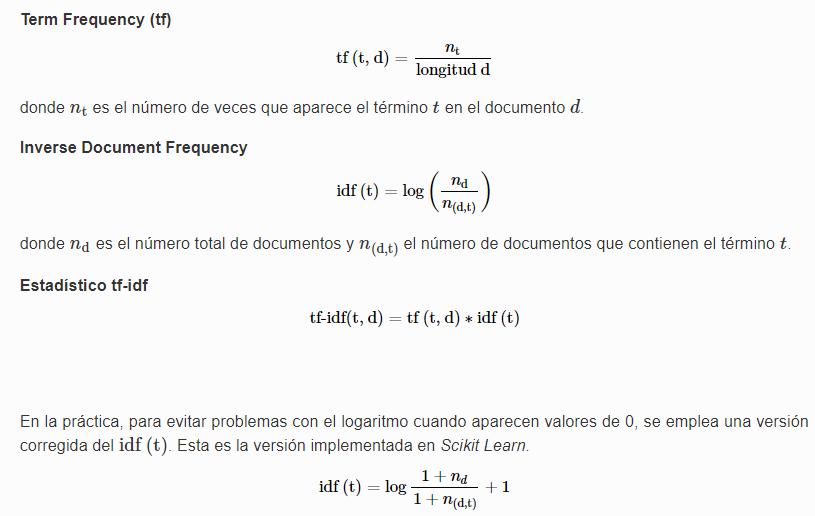

In [29]:
# C√°lculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# N√∫mero de veces que aparece cada t√©rmino en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se a√±ade una columna con el total de t√©rminos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf",ascending=False).tail(10)

id      token  count  total_count        tf
16275  5.609007e+17   traction      1           19  0.052632
16276  5.609007e+17      wheel      1           19  0.052632
42866  8.250489e+17         hq      1           19  0.052632
42867  8.250489e+17  hyperloop      1           19  0.052632
8166   3.546906e+17      walks      1           20  0.050000
8164   3.546906e+17       says      1           20  0.050000
8159   3.546906e+17     barman      1           20  0.050000
8158   3.546906e+17        bar      1           20  0.050000
8168   3.546906e+17       ‚Äúyes      1           20  0.050000
8169   3.546906e+17     ‚Äúyou‚Äôd      1           20  0.050000

In [35]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# N√∫mero de documentos (tweets) en los que aparece cada t√©rmino
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_tweets_aparece'] = idf.groupby('token')['count'].transform(sum)
# C√°lculo del idf
idf['idf'] = np.log(total_documents / idf['n_tweets_aparece'])
idf = idf[["token","n_tweets_aparece", "idf"]].drop_duplicates()
idf.sort_values(by="idf",ascending=False).tail(10)

token  n_tweets_aparece       idf
65052      world               246  3.374280
41277     people               253  3.346222
47034  residents               264  3.303663
57300      tesla               272  3.273810
59086      today               272  3.273810
39584        one               273  3.270140
38284        new               295  3.192636
22823      great               327  3.089651
8724        city               355  3.007494
50471         sf               914  2.061781

In [28]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").tail()

id      token  count  total_count        tf  n_documentos  \
21767  9.287568e+17  dedicated      1           12  0.083333            24   
64375  9.287568e+17      tents      1           12  0.083333            17   
50030  9.287568e+17     stable      1           12  0.083333            12   
7872   9.287568e+17      thank      1           12  0.083333           119   
66741  9.287568e+17     livin‚Ä¶      1           12  0.083333             1   

            idf    tf_idf  
21767  5.701558  0.475130  
64375  6.046398  0.503867  
50030  6.394705  0.532892  
7872   4.100488  0.341707  
66741  8.879612  0.739968

Puede observarse que para el primer tweet (id = 1.195196e+17), todos los t√©rminos que aparecen una vez, tienen el mismo valor de tf, sin embargo, dado que no todos los t√©rminos aparecen con la misma frecuencia en el conjunto de todos los tweets, la correcci√≥n de idf es distinta para cada uno.

De nuevo remarcar que, si bien se ha realizado el c√°lculo de forma manual con fines ilustrativos, en la pr√°ctica, es preferible utilizar implementaciones optimizadas como es el caso de la clase TfidfVectorizer de Scikit Learn.

# Clasificaci√≥n de tweets
